In [1]:
!nvidia-smi

Mon May  5 02:58:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.18.0
Is GPU available: True
Num GPUs Available:  1


In [6]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 10.0 MB/s eta 0:00:00
  At

STEP 1: Import Libraries

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from glob import glob
import os

STEP 2: Set Image Size

In [3]:
IMAGE_SIZE = [224, 224]

STEP 3: Set Paths (update if your path is different in Drive)

In [4]:
train_path = '/content/drive/MyDrive/dataset/train'
valid_path = '/content/drive/MyDrive/dataset/val'

STEP 4: Load Pretrained InceptionV3

In [5]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


Freeze All Layers

In [6]:
for layer in inception.layers:
    layer.trainable = False

STEP 5: Count Classes

In [7]:
folders = glob(train_path + '/*')
num_classes = len(folders)

STEP 6: Add Custom Classifier Head

In [41]:
from tensorflow.keras.layers import Dropout

x = Flatten()(inception.output)
x = Dropout(0.5)(x)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

STEP 7: Compile Model

In [43]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [44]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

STEP 8: Image Augmentation

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Rotate images
    width_shift_range=0.1,    # Translate horizontally
    height_shift_range=0.1,   # Translate vertically
    zoom_range=0.2,           # Random zoom
    shear_range=0.2,          # Shear transform
    horizontal_flip=True,     # Flip images
    fill_mode='nearest'
)

In [46]:
valid_datagen = ImageDataGenerator(rescale = 1./255)

STEP 9: Load Data

In [47]:
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = 16,
    class_mode = 'categorical'
)

validation_set = valid_datagen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = 16,
    class_mode = 'categorical'
)

Found 493 images belonging to 3 classes.
Found 124 images belonging to 3 classes.


STEP 10: Train Model

In [14]:
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/20
31/31 [==============================] - 243s 8s/step - loss: 0.8544 - accuracy: 0.9006 - val_loss: 0.0620 - val_accuracy: 0.9919
Epoch 2/20
31/31 [==============================] - 53s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9919
Epoch 3/20
31/31 [==============================] - 57s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9919
Epoch 4/20
31/31 [==============================] - 49s 2s/step - loss: 0.0411 - accuracy: 0.9939 - val_loss: 0.0435 - val_accuracy: 0.9919
Epoch 5/20
31/31 [==============================] - 61s 2s/step - loss: 0.0401 - accuracy: 0.9919 - val_loss: 0.0241 - val_accuracy: 0.9919
Epoch 6/20
31/31 [==============================] - 55s 2s/step - loss: 0.1832 - accuracy: 0.9878 - val_loss: 6.5336e-04 - val_accuracy: 1.0000
Epoch 7/20
31/31 [==============================] - 57s 2s/step - loss: 0.2072 - accuracy: 0.9919 - val_loss: 1.3910e-04 - val_accuracy: 1.0000
Epoch 8/20


In [15]:
model.save('/content/drive/MyDrive/weapon_detector_inceptionv3.h5')

Verifying the model

Saving background_0222.jpg to background_0222.jpg
1/1 [==============================] - 1s 1s/step


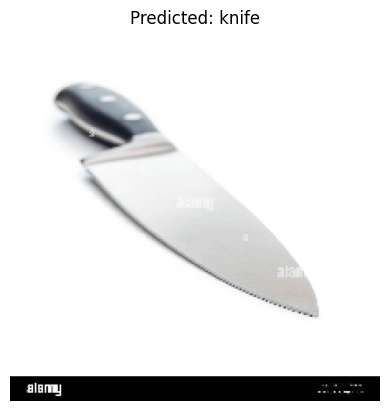

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# Load the model
model = load_model('/content/drive/MyDrive/weapon_detector_inceptionv3.h5')  # Path to your model

# class names
class_names = ['grenade', 'gun', 'knife']

# Upload image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale (if your model expects it)

    # Predict
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


Model is overfitted

STEP 10 again with improvements: Train Model --> (Tunning)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
31/31 [==============================] - 58s 2s/step - loss: 1.2585 - accuracy: 0.8986 - val_loss: 0.0198 - val_accuracy: 0.9919
Epoch 2/30
31/31 [==============================] - 52s 2s/step - loss: 0.0970 - accuracy: 0.9878 - val_loss: 3.4104e-04 - val_accuracy: 1.0000
Epoch 3/30
31/31 [==============================] - 48s 2s/step - loss: 5.0667e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 4/30
31/31 [==============================] - 48s 2s/step - loss: 0.0309 - accuracy: 0.9939 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 5/30
31/31 [==============================] - 49s 2s/step - loss: 0.0951 - accuracy: 0.9899 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 6/30
31/31 [==============================] - 49s 2s/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0144 - val_accuracy: 0.9919
Epoch 7/30
31/31 [==============================] - 49s 2s/step - loss: 0.0569 - accuracy: 0.9959 - val_loss: 4.4277e-05 - val_accuracy: 1.0000
Epoch 8/

Verifying

Saving knife_0009.jpg to knife_0009.jpg
1/1 [==============================] - 1s 1s/step


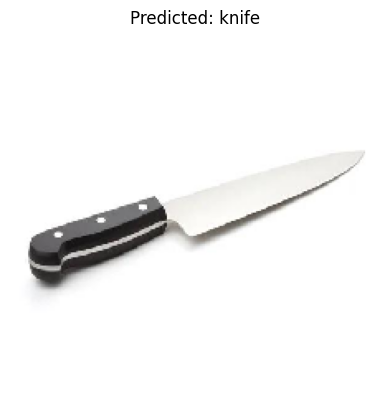

In [49]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# Load the model
model = load_model('/content/best_model.h5')  # Path to your model

# class names
class_names = ['grenade', 'gun', 'knife']

# Upload image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale (if your model expects it)

    # Predict
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


In [50]:
from tensorflow.keras.models import load_model

model = load_model('/content/best_model.h5')

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 291 images belonging to 3 classes.


In [52]:
y_pred = model.predict(test_set)

19/19 [==============================] - 25s 1s/step


In [53]:
import numpy as np
predicted_classes = np.argmax(y_pred, axis=1)

In [54]:
true_classes = test_set.classes

Calculating accuracy

In [55]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

report = classification_report(true_classes, predicted_classes, target_names=test_set.class_indices.keys())
print(report)


Test Accuracy: 89.69%
              precision    recall  f1-score   support

     grenade       0.91      0.83      0.87        83
     handgun       0.82      0.97      0.89       108
       knife       1.00      0.87      0.93       100

    accuracy                           0.90       291
   macro avg       0.91      0.89      0.90       291
weighted avg       0.91      0.90      0.90       291

